# Bike Sharing Dataset

### EDA

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set(style = 'white')

In [2]:
bike_df = pd.read_csv('../data/SeoulBikeData.csv', engine = 'python')

bike_df.columns = ['date', 'bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
                   'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

bike_df.head()

date  bike_count  hour  temperature  humidity  wind_speed  \
0  01/12/2017         254     0         -5.2        37         2.2   
1  01/12/2017         204     1         -5.5        38         0.8   
2  01/12/2017         173     2         -6.0        39         1.0   
3  01/12/2017         107     3         -6.2        40         0.9   
4  01/12/2017          78     4         -6.0        36         2.3   

   visibility  dew_point_temp  solar_radiation  rainfall  snowfall  season  \
0        2000           -17.6              0.0       0.0       0.0  Winter   
1        2000           -17.6              0.0       0.0       0.0  Winter   
2        2000           -17.7              0.0       0.0       0.0  Winter   
3        2000           -17.6              0.0       0.0       0.0  Winter   
4        2000           -18.6              0.0       0.0       0.0  Winter   

      holiday functioning_day  
0  No Holiday             Yes  
1  No Holiday             Yes  
2  No Holiday             Yes  
3  No Holiday             Yes  
4  No Holiday             Yes

In [3]:
bike_df['date'] = pd.to_datetime(bike_df['date'], format = '%d/%m/%Y')
bike_df['hour'] = bike_df['hour'].astype('category')
# bike_df['datehour'] =  bike_df['date'] + pd.to_timedelta(bike_df['hour'], unit = 'h')
bike_df['season'] = bike_df['season'].astype('category')
bike_df['holiday'] = bike_df['holiday'].astype('category')
bike_df['functioning_day'] = bike_df['functioning_day'].astype('category')
bike_df['median_bike_count'] = (bike_df['bike_count'] > np.median(bike_df['bike_count'])).astype('category')

In [4]:
bike_df.select_dtypes(exclude = ['category']).describe().transpose()

count         mean         std   min    25%      50%  \
bike_count       8760.0   704.602055  644.997468   0.0  191.0   504.50   
temperature      8760.0    12.882922   11.944825 -17.8    3.5    13.70   
humidity         8760.0    58.226256   20.362413   0.0   42.0    57.00   
wind_speed       8760.0     1.724909    1.036300   0.0    0.9     1.50   
visibility       8760.0  1436.825799  608.298712  27.0  940.0  1698.00   
dew_point_temp   8760.0     4.073813   13.060369 -30.6   -4.7     5.10   
solar_radiation  8760.0     0.569111    0.868746   0.0    0.0     0.01   
rainfall         8760.0     0.148687    1.128193   0.0    0.0     0.00   
snowfall         8760.0     0.075068    0.436746   0.0    0.0     0.00   

                     75%      max  
bike_count       1065.25  3556.00  
temperature        22.50    39.40  
humidity           74.00    98.00  
wind_speed          2.30     7.40  
visibility       2000.00  2000.00  
dew_point_temp     14.80    27.20  
solar_radiation     0.93     3.52  
rainfall            0.00    35.00  
snowfall            0.00     8.80

In [5]:
bike_df.select_dtypes(include = ['category']).describe().transpose()

count unique         top  freq
hour               8760     24           0   365
season             8760      4      Spring  2208
holiday            8760      2  No Holiday  8328
functioning_day    8760      2         Yes  8465
median_bike_count  8760      2       False  4380

#### Date and Time Variables

In [6]:
bike_date_df = bike_df.groupby(['date']).agg(bike_count = ('bike_count', 'sum'), 
                                             season = ('season', 'first'), 
                                             holiday = ('holiday', 'first'), 
                                             functioning_day = ('functioning_day', 'first')).reset_index()

bike_date_df['day'] = bike_date_df['date'].dt.day_name()

In [7]:
fig = px.line(bike_date_df, x = 'date', y = 'bike_count', labels = {'date' : 'Date', 'bike_count': '# of Bikes Rented'}, 
              title = 'Daily Trend Plot: # of Bikes Rented')
fig.update_layout(hovermode = 'x')
fig.show()

There are certain days when no bike is rented as shown in the trend-plot above. By looking at functioning day variable, one can see that on non-functioning days, bike count is 0.

In [8]:
bike_date_df[bike_date_df['functioning_day'] == 'No']['date']
# bike_df[bike_df['bike_count'] == 0]['date'].unique()

131   2018-04-11
160   2018-05-10
291   2018-09-18
292   2018-09-19
301   2018-09-28
303   2018-09-30
305   2018-10-02
307   2018-10-04
309   2018-10-06
312   2018-10-09
337   2018-11-03
340   2018-11-06
343   2018-11-09
Name: date, dtype: datetime64[ns]

In [9]:
bike_date_df.groupby(['season']).agg(first_date = ('date', 'first'), last_date = ('date', 'last')).reset_index()

season first_date  last_date
0  Autumn 2018-09-01 2018-11-30
1  Spring 2018-03-01 2018-05-31
2  Summer 2018-06-01 2018-08-31
3  Winter 2017-12-01 2018-02-28

In [10]:
fig = px.box(bike_df[bike_df['functioning_day'] == 'Yes'], x = 'season', y = 'bike_count', 
             labels = {'season' : 'Season', 'bike_count': '# of Bikes Rented'}, 
             title = 'Box Plot: # of Bikes Rented vs Season')
fig.show()

From the above box-plot and bike count trend-plot, one can observe that colder weather (entire Winter, early Spring and late Autumn) hampers bike rentals.

In [11]:
bike_date_df[bike_date_df['holiday'] == 'Holiday']['date']

21    2017-12-22
23    2017-12-24
24    2017-12-25
30    2017-12-31
31    2018-01-01
76    2018-02-15
77    2018-02-16
78    2018-02-17
90    2018-03-01
151   2018-05-01
172   2018-05-22
187   2018-06-06
257   2018-08-15
296   2018-09-23
297   2018-09-24
298   2018-09-25
306   2018-10-03
312   2018-10-09
Name: date, dtype: datetime64[ns]

In [12]:
fig = px.box(bike_df[bike_df['functioning_day'] == 'Yes'], x = 'holiday', y = 'bike_count',
             labels = {'holiday' : 'Holiday', 'bike_count': '# of Bikes Rented'}, 
             title = 'Box Plot: # of Bikes Rented vs Holiday')
fig.show()

In [13]:
fig = px.box(bike_date_df[bike_date_df['functioning_day'] == 'Yes'], x = 'day', y = 'bike_count', 
             labels = {'day' : 'Day', 'bike_count': '# of Bikes Rented'}, 
             title = 'Box Plot: # of Bikes Rented vs Day of the Week')
fig.show()

From above box-plots, one can see that there are lower bike rentals on weekends and holidays as compared to working days. But one needs to test the significance of the expected value.

In [14]:
fig = px.box(bike_df[bike_df['functioning_day'] == 'Yes'], x = 'hour', y = 'bike_count',
             labels = {'hour' : 'Hour', 'bike_count': '# of Bikes Rented'}, 
             title = 'Box Plot: # of Bikes Rented vs Hour of the Day')
fig.show()

The bike sharing is predominant from 5 p.m. to 10 p.m.

#### Weather Condition Variables

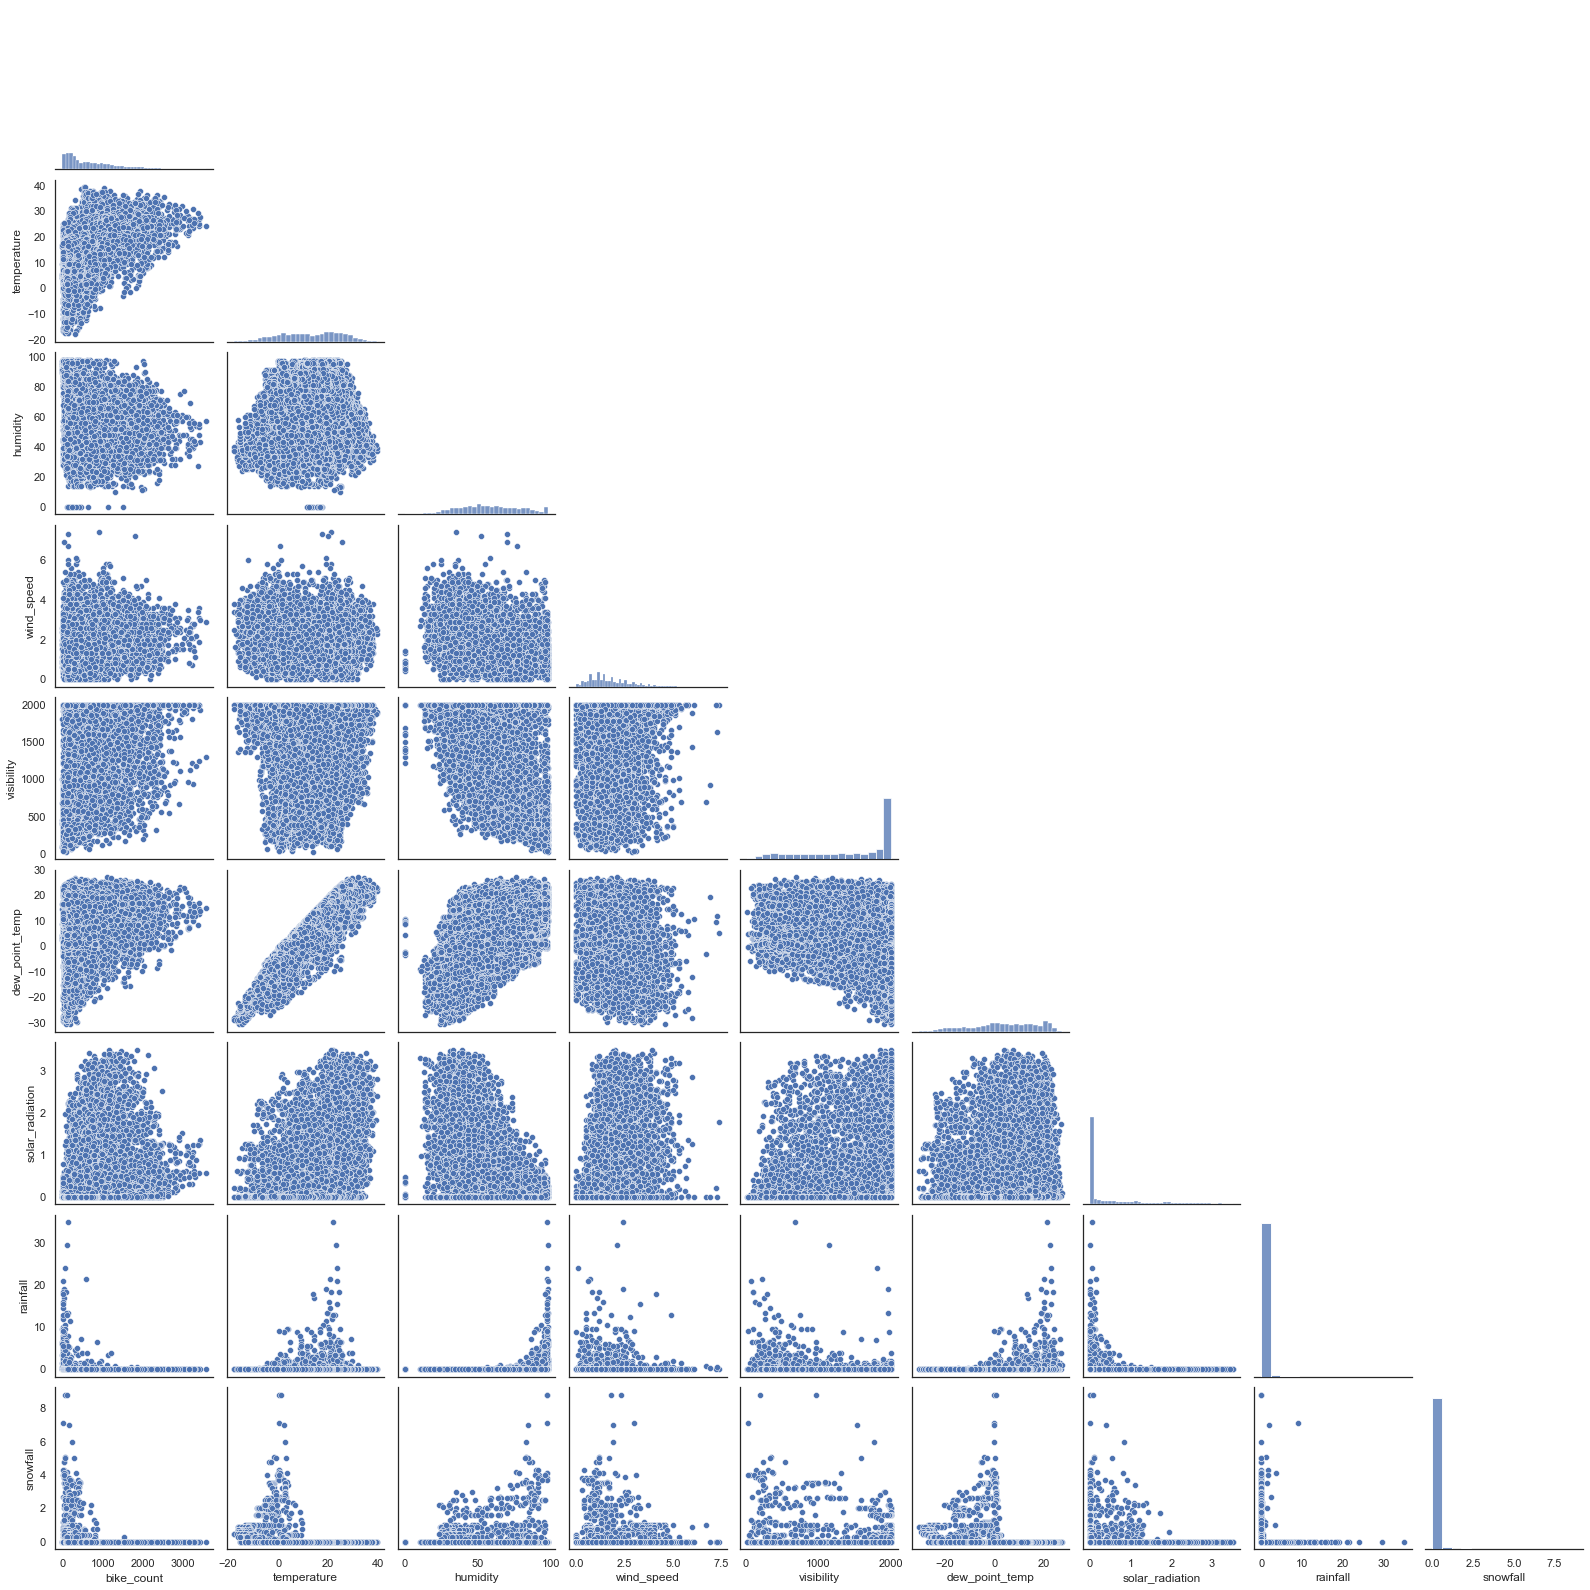

In [15]:
sns.pairplot(bike_df[bike_df['functioning_day'] == 'Yes'].select_dtypes(exclude = ['category']), corner = True)
plt.show()

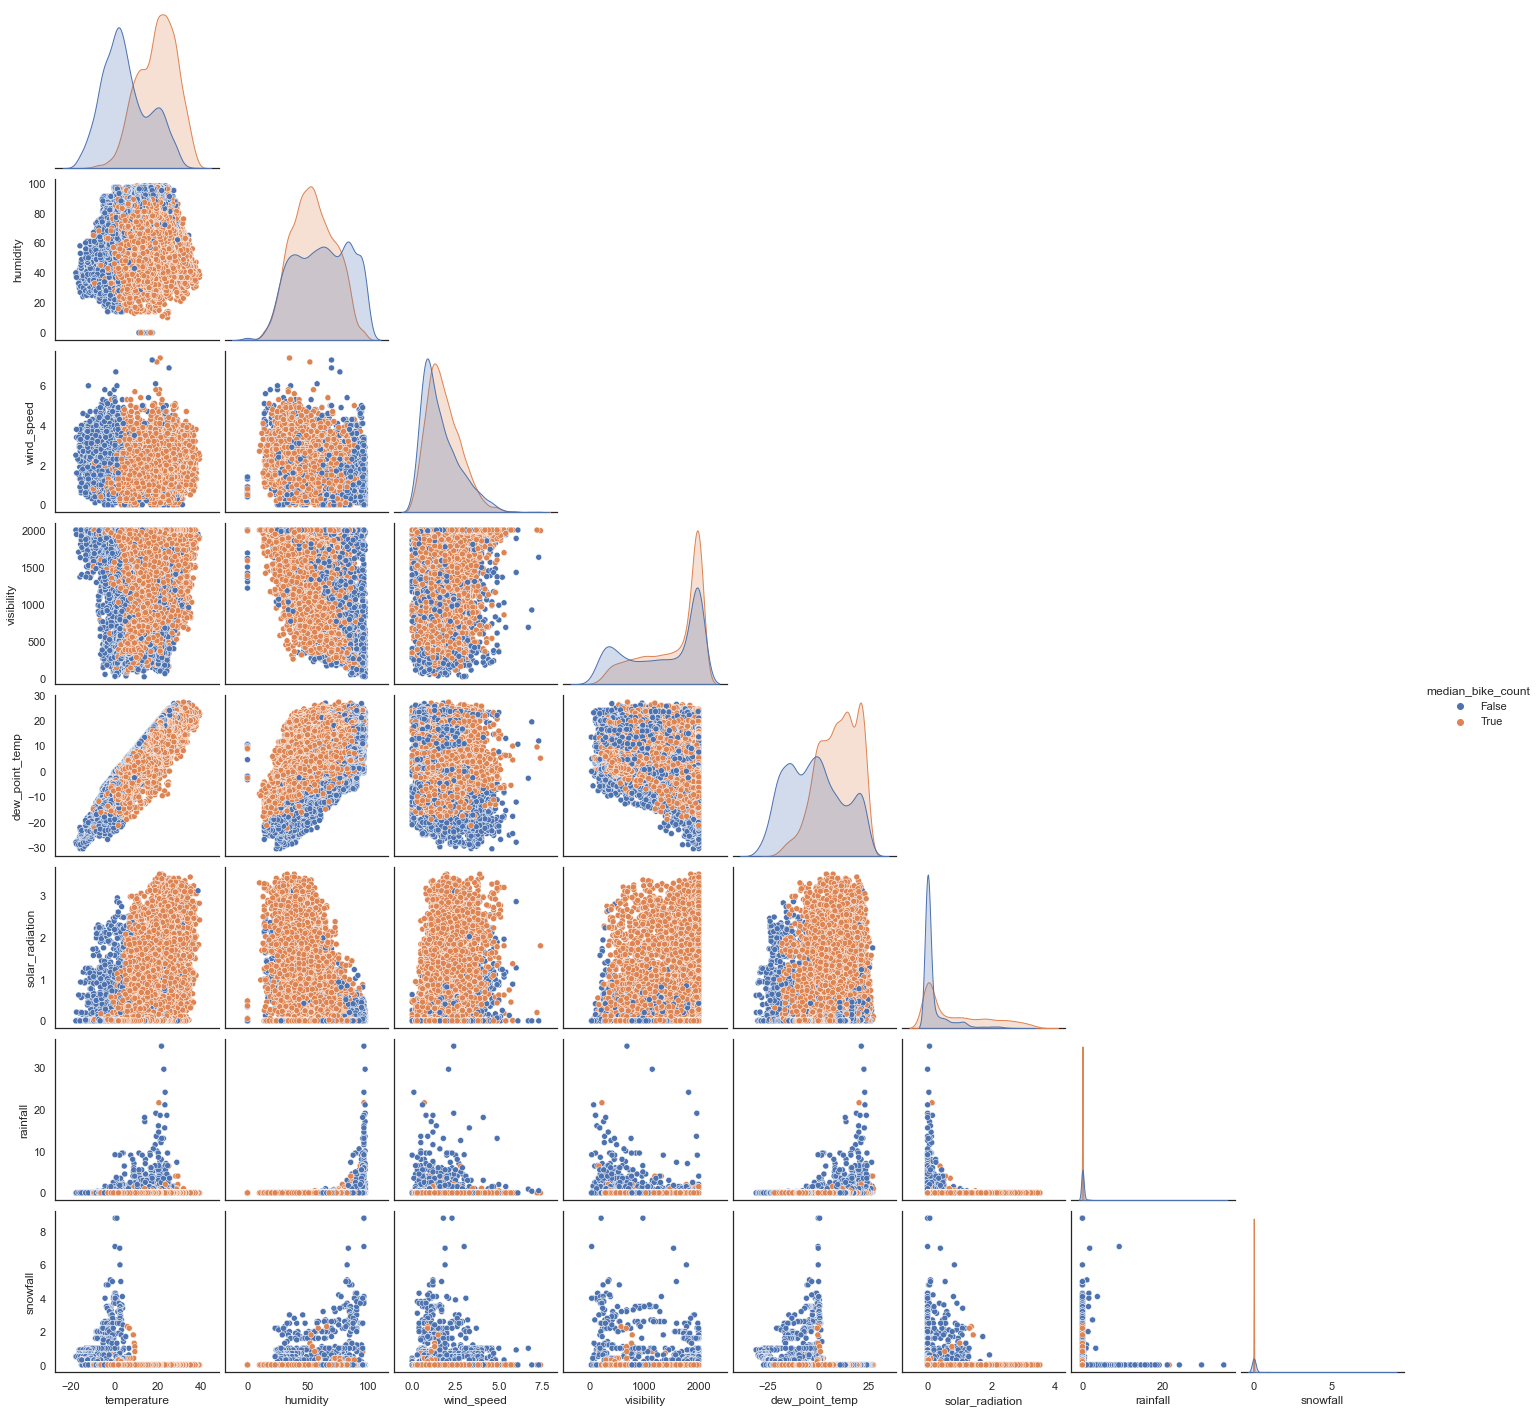

In [16]:
sns.pairplot(bike_df[list(bike_df.dtypes[(bike_df.dtypes == 'category') == False].index) 
                     + ['median_bike_count']][bike_df['functioning_day'] == 'Yes'].drop('bike_count', axis = 1), 
             hue = 'median_bike_count', corner = True)
plt.show()

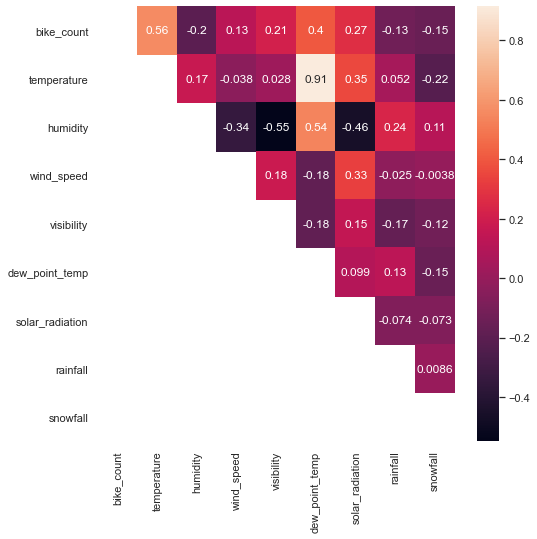

In [17]:
mask = np.zeros_like(bike_df[bike_df['functioning_day'] == 'Yes'].select_dtypes(exclude = ['category']).corr())
mask[np.tril_indices_from(mask)] = 1
plt.figure(figsize=(8, 8))
sns.heatmap(bike_df[bike_df['functioning_day'] == 'Yes'].select_dtypes(exclude = ['category']).corr(), 
            mask = mask, annot = True, square = False)
plt.show()

The temperature and dew-point temperature variables are highly correlated. One has to be careful with multi-collinearity issue.

In [18]:
X = add_constant(bike_df[bike_df['functioning_day'] == 'Yes'])
X = X.drop(['date', 'hour', 'season', 'holiday', 'functioning_day', 'bike_count', 'median_bike_count'], axis = 1)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

const              386.985596
temperature         87.152504
humidity            20.132908
wind_speed           1.198871
visibility           1.565867
dew_point_temp     116.219367
solar_radiation      1.975087
rainfall             1.080975
snowfall             1.093974
dtype: float64

In [19]:
Y = X.drop(['dew_point_temp'], axis = 1)
pd.Series([variance_inflation_factor(Y.values, i) for i in range(Y.shape[1])], index = Y.columns)

const              47.068517
temperature         1.552337
humidity            2.399677
wind_speed          1.195768
visibility          1.554150
solar_radiation     1.880399
rainfall            1.067003
snowfall            1.088773
dtype: float64

By removing dew-point temperture, all the variables have VIF less than 10.